In [1]:
import cv2
import os
import gtsam

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
import transforms3d as t3d
import matplotlib.cm as cm

from tqdm import tqdm
from pr2_utils import bresenham2D
from gtsam import Pose2, Pose3, Rot3, Point3, PriorFactorPose3, BetweenFactorPose3
from icp_warm_up.tools import ICP

dataset = 20

# Reading the pose transformations from npy files

cumulative_poses = True
icp_poses = np.load(f"./icp_warm_up/icp_poses_{dataset}.npy")

# cumulative_poses = True
# icp_poses = np.load(f"./icp_warm_up/icp_poses_{dataset}.npy")


print(icp_poses.shape)

(4961, 4, 4)


In [2]:
def velocity_right_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[0, :] + counts[2, :]) / 2 * 0.0022) / delta_t


def velocity_left_encoder(counts, timestamps):
    delta_t = timestamps[1:] - timestamps[:-1]
    delta_t = [timestamps[1] - timestamps[0]] + list(delta_t)
    return ((counts[1, :] + counts[3, :]) / 2 * 0.0022) / delta_t


def motion_model(pose, v, omega, dt):
    x, y, theta = pose
    x += v * np.cos(theta) * dt
    y += v * np.sin(theta) * dt
    theta += omega * dt
    return np.array([x, y, theta])


def sync_time_stamps(t1, t2):
    t1 = np.array(t1)
    t2 = np.array(t2)
    t1 = t1.reshape(-1, 1)
    t2 = t2.reshape(1, -1)
    return np.argmin(np.abs(t1 - t2), axis=1)


def image_to_pc(bgr_img, disp_img):
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

    # From writeup, compute correspondence
    height, width = disp_img.shape

    dd = np.array(-0.00304 * disp_img + 3.31)
    depth = 1.03 / dd
    mesh = np.meshgrid(np.arange(0, height), np.arange(0, width), indexing='ij')  
    i_idxs = mesh[0].flatten()
    j_idxs = mesh[1].flatten()

    rgb_i = np.array((526.37 * i_idxs + 19276 - 7877.07 * dd.flatten()) / 585.051, dtype=np.int32)  # force int for indexing
    rgb_j = np.array((526.37 * j_idxs + 16662) / 585.051, dtype=np.int32)

    # Some may be out of bounds, just clip them
    rgb_i = np.clip(rgb_i, 0, height - 1)
    rgb_j = np.clip(rgb_j, 0, width - 1)

    colors = rgb_img[rgb_i, rgb_j]

    # Let's visualize the image using our transformation to make sure things look correct (using bgr for opencv)
    bgr_colors = bgr_img[rgb_i, rgb_j]
    cv2.imshow("color", bgr_colors.reshape((height, width, 3)))

    uv1 = np.vstack([j_idxs, i_idxs, np.ones_like(i_idxs)])
    K = np.array([[585.05, 0, 242.94],
                  [0, 585.05, 315.84],
                  [0, 0, 1]])

    # Project images to 3d points
    points = depth.flatten() * (np.linalg.inv(K) @ uv1)

    oRr = np.array([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
    # We want rRo because we have points in optical frame and want to move them to the regular frame.
    points = oRr.T @ points

    return points, colors

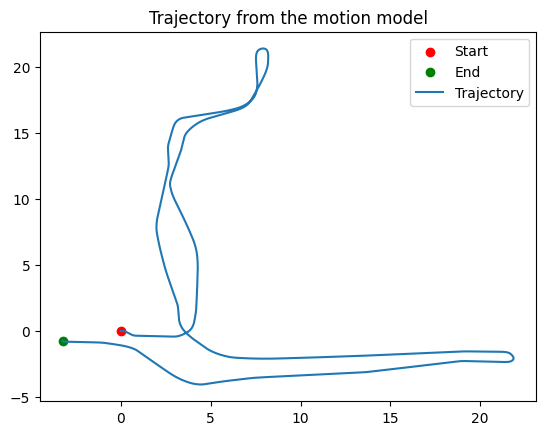

/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_80805/1612798077.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)


In [3]:
with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_angle_min = data["angle_min"] # start angle of the scan [rad]
    lidar_angle_max = data["angle_max"] # end angle of the scan [rad]
    lidar_angle_increment = data["angle_increment"] # angular distance between measurements [rad]
    lidar_range_min = data["range_min"] # minimum range value [m]
    lidar_range_max = data["range_max"] # maximum range value [m]
    lidar_ranges = data["ranges"]     # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

    # Clipping the ranges
    lidar_ranges[lidar_ranges < lidar_range_min] = 0
    lidar_ranges[lidar_ranges > lidar_range_max] = 0
    lidar_ranges = lidar_ranges.T

# Extracting point clouds from lidar data
def extract_pc(lidar_ranges, lidar_angle_increment):
    pc = []
    for i in range(len(lidar_ranges)):
        ranges = lidar_ranges[i]
        angles = np.arange(lidar_angle_min, lidar_angle_max + 1e-6, lidar_angle_increment)
        x = ranges * np.cos(angles)
        y = ranges * np.sin(angles)
        z = np.zeros_like(x)

        # Removing all zeros
        x = x[ranges != 0]
        y = y[ranges != 0]
        z = z[ranges != 0]
        pc.append(np.stack([x, y, z], axis=1))
    return pc

# Similarity between two LiDAR scans
def lidar_similarity(ranges_a, ranges_b):
    # For each point in pc_a, find the closest point in pc_b
    # Compute the distance between the two points
    # Return the average distance
    return np.mean(np.abs(ranges_a - ranges_b))

synced_encoder_stamps = sync_time_stamps(imu_stamps, lidar_stamps)
# synced_lidar_stamps = sync_time_stamps(imu_stamps, lidar_stamps)

v_left = velocity_left_encoder(encoder_counts, encoder_stamps)
v_right = velocity_right_encoder(encoder_counts, encoder_stamps)

# Motion model
axel_length = 0.31115 # meters
wheel_diameter = 0.254 # meters

pose_motion = np.zeros((3))
x_traj = [0]
y_traj = [0]
poses_motion = []

for i in range(1, len(imu_angular_velocity[2])):
    omega = imu_angular_velocity[2][i] # yaw angular velocity
    dt = imu_stamps[i] - imu_stamps[i - 1]
    encoder_ind = synced_encoder_stamps[i]
    v = (v_left[encoder_ind] + v_right[encoder_ind]) / 2
    pose_motion = motion_model(pose_motion, v, omega, dt)
    poses_motion.append(pose_motion)

poses_motion = np.array(poses_motion).T
# Beginning point
plt.scatter(0, 0, c='r')
# Ending point
plt.scatter(pose_motion[0], pose_motion[1], c='g')
plt.title("Trajectory from the motion model")
plt.plot(poses_motion[0], poses_motion[1])
plt.legend(["Start", "End", "Trajectory"])
plt.show()

pc = extract_pc(lidar_ranges, lidar_angle_increment)

In [4]:
similarities = []
for i in tqdm(range(len(pc) - 1)):
    sim = []
    for j in range(i + 1, len(pc)):
        similarity = lidar_similarity(lidar_ranges[i], lidar_ranges[j])
        sim.append(similarity)
    similarities.append(np.asarray(sim))

100%|██████████| 4961/4961 [00:40<00:00, 121.15it/s]


Text(0.5, 1.0, 'Histogram of LiDAR scan similarities')

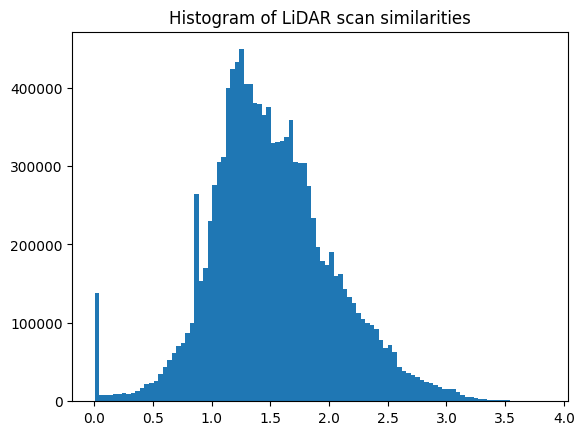

In [5]:
sim = [similarities[i][j] for i in range(len(similarities)) for j in range(len(similarities[i]))]
plt.hist(sim, bins=100)
plt.title("Histogram of LiDAR scan similarities")

Factor graph optimization with GTSAM

In [6]:
#****** Test Script to test GTSAM - python installation ******#

def test_create_pose2():
  # Create a 2D pose with x, y, and theta (rotation)
  pose = gtsam.Pose2(1.0, 2.0, 0.5)
  print("Pose2 created:", pose)

  return pose

def test_create_prior():
  # Create a prior factor on a Pose2
  prior_noise = gtsam.noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1])
  pose_key = gtsam.symbol('x', 1)
  prior_factor = gtsam.PriorFactorPose2(pose_key, gtsam.Pose2(0, 0, 0), prior_noise)
  print("Prior factor created:", prior_factor)
  
  return prior_factor

# Run basic tests
pose = test_create_pose2()
prior = test_create_prior()

print("GTSAM installation seems to be working!")

Pose2 created: (1, 2, 0.5)

Prior factor created: PriorFactor on x1
  prior mean:  (0, 0, 0)
isotropic dim=3 sigma=0.1

GTSAM installation seems to be working!


100%|██████████| 4948/4948 [00:00<00:00, 127506.18it/s]


4962


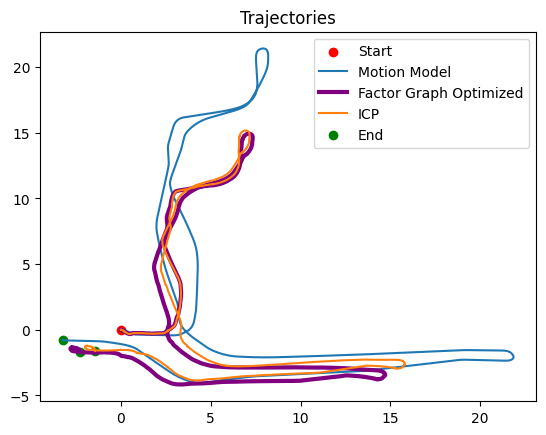

In [7]:
# Factor graph optimization
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()
noise_model = gtsam.noiseModel.Isotropic.Sigma(6, 0.1)

# Starting from the origin
prior_mean = Pose3(Rot3(), Point3(0, 0, 0))
graph.add(PriorFactorPose3(0, prior_mean, noise_model))

prior_pose = np.eye(4)

# # Adding the odometry data
gap = 1
consecutive_poses = []
graph.add(BetweenFactorPose3(0, 1, Pose3(np.linalg.inv(icp_poses[0])), noise_model))
for i in tqdm(range(0, len(icp_poses) - 1)):
    # ICP poses are from the current frame to the world frame
    if cumulative_poses:
        loop_pose = np.linalg.inv(icp_poses[i + gap]) @ icp_poses[i]
    else:
        loop_pose = icp_poses[i]
    # print(f"Pose at time {i} is {icp_poses[i, :3, 3]} at time {i + 1} is {icp_poses[i + 1, :3, 3]} and the difference is loop_pose {loop_pose[:3, 3]}")
    graph.add(BetweenFactorPose3(i + 1, i + gap + 1, Pose3(loop_pose), noise_model))

# # Adding the loop closure
gap = 12
for i in tqdm(range(0, len(icp_poses) - gap - 1)):
    if cumulative_poses:
        loop_pose = np.linalg.inv(icp_poses[i]) @ icp_poses[i + gap]
    else:
        loop_pose = np.eye(4)
        for j in range(gap):
            loop_pose = loop_pose @ icp_poses[i + j]
    graph.add(BetweenFactorPose3(i + 1, i + gap + 1, Pose3(loop_pose), noise_model))

# Similarity between two LiDAR scans
# for i in tqdm(range(len(pc) - 1)):
#     for j in range(i + 1, len(pc) - 1):
#         # Threshold is 0.5 for dataset 20
#         # Threshold is 0.8 for dataset 21
#         if similarities[i][j - i - 1] < 0.8 and similarities[i][j - i - 1] > 0 and np.sum(np.abs(icp_poses[i, :3, 3] - icp_poses[j, :3, 3])) < 0.8:
#             if cumulative_poses:
#                 loop_pose = np.linalg.inv(icp_poses[i]) @ icp_poses[j]
#             else:
#                 loop_pose = np.eye(4)
#                 for k in range(j - i + 1):
#                     loop_pose = loop_pose @ icp_poses[i + k]
#             graph.add(BetweenFactorPose3(i + 1, j + 1, Pose3(loop_pose), noise_model))

# Adding the current guesses
motion_current = np.zeros(3)
initial_estimate.insert(0, Pose3(Rot3(), Point3(0, 0, 0)))

synced_imu_stamps = sync_time_stamps(imu_stamps, lidar_stamps)

for i in range(len(icp_poses)):
    ind = synced_imu_stamps[i]
    delta_current = poses_motion[:, ind]
    R = t3d.euler.euler2mat(0, 0, delta_current[2])
    initial_estimate.insert(i + 1, Pose3(Rot3(R), Point3(motion_current[0], motion_current[1], 0)))
    motion_current = poses_motion[:, ind]

print(len(initial_estimate.keys()))
# Optimize the graph
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()


optimized_poses = []
for i in range(len(icp_poses) + 1):
    optimized_pose = np.eye(4)
    R = result.atPose3(i).rotation().matrix()
    optimized_pose[:3, :3] = R
    optimized_pose[:3, 3] = result.atPose3(i).translation()
    optimized_poses.append(optimized_pose)

optimized_poses = np.array(optimized_poses)

# ICP coordinates
current_pose = np.eye(4)
icp_coords = []
for i in range(len(icp_poses)):
    if cumulative_poses:
        icp_coords.append(icp_poses[i, :3, 3])
    else:
        icp_coords.append(current_pose[:3, 3])
        current_pose = current_pose @ icp_poses[i]
icp_coords = np.array(icp_coords)

# Beginning point
plt.scatter(0, 0, c='red')
# Ending point
plt.title("Trajectories")
plt.plot(poses_motion[0], poses_motion[1])
plt.plot(optimized_poses[:, 0, 3], optimized_poses[:, 1, 3], c='purple', linewidth=3)
plt.plot(icp_coords[:, 0], icp_coords[:, 1])

plt.scatter(optimized_poses[-1, 0, 3], optimized_poses[-1, 1, 3], c='green')
plt.scatter(poses_motion[0, -1], poses_motion[1, -1], c='green')
plt.scatter(icp_coords[-1, 0], icp_coords[-1, 1], c='green')

plt.legend(["Start", "Motion Model", "Factor Graph Optimized", "ICP", "End"])
plt.show()

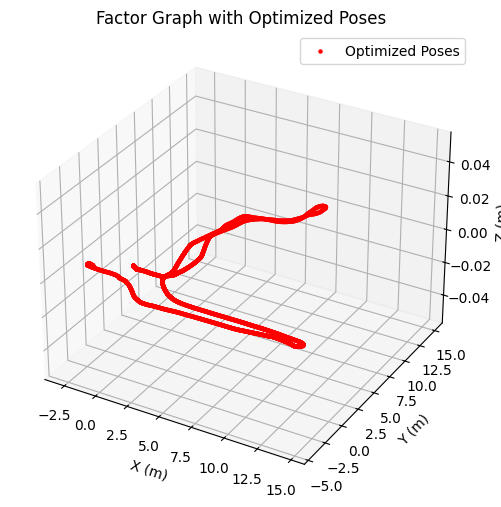

In [8]:
def plot_factor_graph(graph, result, loop_closure_steps=10):
    """
    Visualize the factor graph and optimized trajectory.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')  # 3D plot
    
    poses = []
    edges = []

    # Extract optimized poses
    for i in range(len(result.keys())):
        pose = result.atPose3(i)
        position = pose.translation()
        poses.append(position)

    poses = np.array(poses)

    # Plot poses
    ax.scatter(poses[:, 0], poses[:, 1], poses[:, 2], c='r', label='Optimized Poses', s=5)

    # Plot edges (odometry + loop closures)
    for i in range(len(poses) - 1):
        edges.append([poses[i], poses[i + 1]])  # Odometry edges

    # Loop closures (every 10th pose)
    for i in range(10, len(poses), loop_closure_steps):
        edges.append([poses[i - 10], poses[i]])  # Loop closure edges

    for edge in edges:
        edge = np.array(edge)
        ax.plot(edge[:, 0], edge[:, 1], edge[:, 2], 'k-', alpha=1)  # Edges in black

    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title("Factor Graph with Optimized Poses")
    ax.legend()
    plt.show()

# Call the function after optimizing the graph
plot_factor_graph(graph, result)

100%|██████████| 4961/4961 [01:46<00:00, 46.75it/s]
/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_80805/4147655579.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(trajectory))


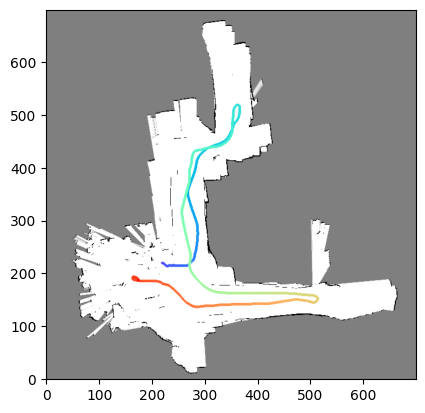

In [9]:
center = 350

# Intially all cells are empty
odds_map = np.zeros((center * 2, center * 2, 1), dtype=np.float32)
occupancy_map = np.zeros((center * 2, center * 2, 1), dtype=np.float32)
center = 220

log = np.log(4)
ratio = 20
min_odds = -20
max_odds = -min_odds

current_pose = np.eye(4)
trajectory = []

for i in tqdm(range(len(optimized_poses) - 1)):
    current_pc = pc[i].T
    current_pose = optimized_poses[i]
    # Adding the 1s for the homogeneous coordinates
    current_pc = np.vstack([current_pc, np.ones_like(current_pc[0])])
    # Transforming the point cloud to the world frame
    current_pc = current_pose @ current_pc
    current_pc = current_pc[:3]
    # Filtering the tall points
    current_pc = current_pc[:, current_pc[2] < 1]
    # Current Coorinates in the world frame
    x_world = int(current_pose[0, 3] * ratio + center)
    y_world = int(current_pose[1, 3] * ratio + center)
    trajectory.append([x_world, y_world])
    # Creating the occupancy map
    for j in range(current_pc.shape[1]):
        x = int(current_pc[0, j] * ratio + center)
        y = int(current_pc[1, j] * ratio + center)
        
        x = np.clip(x, 0, 699)
        y = np.clip(y, 0, 699)

        # Using Bresnham to find rays
        rays = bresenham2D(x_world, y_world, x, y).T
        # Free rays
        rays = np.array(rays, dtype=np.int32)
        rays = np.clip(rays, 0, 699)
        odds_map[rays[:, 1], rays[:, 0], 0] -= log
        # Occupied cell
        odds_map[y, x, 0] += 2 * log 

odds_map = np.clip(odds_map, min_odds, max_odds)
# Converting the odds map to the occupancy map
occupancy_map = 1 / (1 + np.exp(odds_map))

# Adding the trajectory in rainbow colors to the occupancy map
def convert_occupancy_to_rgb(occupancy_map, trajectory):
    """
    Convert a (x, x, 1) B&W occupancy map to an RGB image with a trajectory in rainbow colors.
    
    Parameters:
    - occupancy_map: numpy array of shape (H, W, 1) with values 0 (free) and 1 (obstacle)
    - trajectory: list of (x, y) points representing the path
    
    Returns:
    - rgb_image: numpy array of shape (H, W, 3) representing the colored map
    """
    # Convert single-channel occupancy map to 3-channel grayscale image
    rgb_image = np.repeat(occupancy_map * 255, 3, axis=2).astype(np.uint8)

    # Generate colors for the trajectory using a rainbow colormap
    cmap = cm.get_cmap("rainbow", len(trajectory))
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(len(trajectory))]

    # Draw the trajectory
    for i, (x, y) in enumerate(trajectory):
        cv2.circle(rgb_image, (x, y), radius=2, color=colors[i], thickness=-1)

    return rgb_image

rgb_image = convert_occupancy_to_rgb(occupancy_map, trajectory)
plt.imshow(rgb_image, origin='lower')

-20.0 20.0


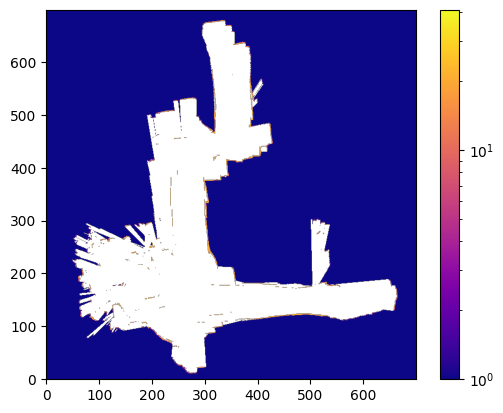

In [10]:
import matplotlib

print(odds_map.min(), odds_map.max())
plt.imshow(odds_map + 1, norm=matplotlib.colors.LogNorm(vmin=21 + odds_map.min(), vmax=21 + odds_map.max()), origin="lower", cmap="plasma")
plt.colorbar()

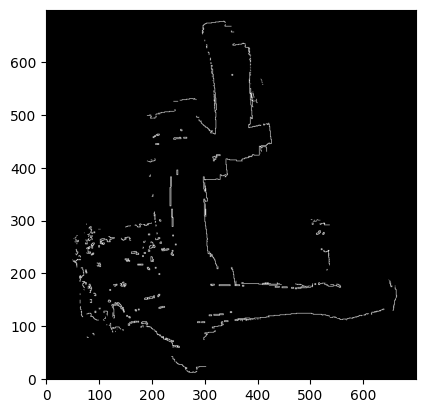

In [11]:
# Extracting the edges
edges = np.zeros_like(occupancy_map)
for i in range(1, occupancy_map.shape[0] - 1):
    for j in range(1, occupancy_map.shape[1] - 1):
        if occupancy_map[i, j] > 0.5:
            # Check if there is a free cell around
            if np.any(occupancy_map[i - 1:i + 2, j - 1:j + 2] < 0.5):
                edges[i, j] = 1
plt.imshow(edges, cmap='gray', origin='lower')

In [12]:
num_images = len(os.listdir(f"../dataRGBD/RGB{dataset}"))
print(num_images)

def sync_time_stamps(t1, t2):
    t1 = np.array(t1)
    t2 = np.array(t2)
    t1 = t1.reshape(-1, 1)
    t2 = t2.reshape(1, -1)
    return np.argmin(np.abs(t1 - t2), axis=1)

# Reading the data
with np.load("../data/Hokuyo%d.npz"%dataset) as data:
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans
with np.load("../data/Kinect%d.npz"%dataset) as data:
    disp_stamps = data["disparity_time_stamps"] # acquisition times of the disparity images
    rgb_stamps = data["rgb_time_stamps"] # acquisition times of the rgb images



# Syncing everything with the disparity images
synced_lidar = sync_time_stamps(disp_stamps, lidar_stamps)
synced_rgb = sync_time_stamps(disp_stamps, rgb_stamps)

print(synced_lidar.shape, synced_rgb.shape, disp_stamps.shape)

2289
(2407,) (2407,) (2407,)


100%|██████████| 2405/2405 [01:40<00:00, 24.03it/s]
/var/folders/1y/87vkwc9x32lcthv8n1nxqhz80000gn/T/ipykernel_80805/1627218795.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(trajectory))


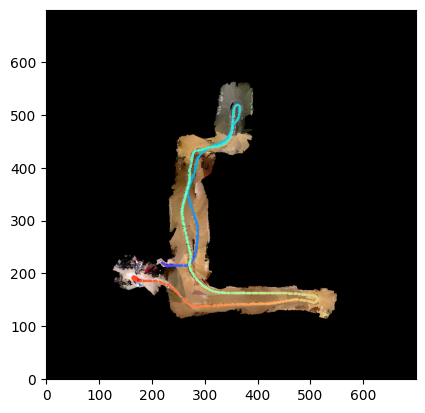

In [13]:
map_center = 350
map_ratio = 20
texture_map = np.zeros((2 * map_center, 2 * map_center, 3), dtype=np.uint8)

map_center = 220
# Adding the trajectory in rainbow colors to the occupancy map
def convert_texture_to_rgb(texture_map, trajectory):
    """
    Convert a (x, x, 3) texture map to an RGB image with a trajectory in rainbow colors.
    
    Parameters:
    - text_map: numpy array of shape (H, W, 3)
    - trajectory: list of (x, y) points representing the path
    
    Returns:
    - rgb_image: numpy array of shape (H, W, 3) representing the colored map
    """

    # Generate colors for the trajectory using a rainbow colormap
    cmap = cm.get_cmap("rainbow", len(trajectory))
    colors = [tuple(int(c * 255) for c in cmap(i)[:3]) for i in range(len(trajectory))]

    # Draw the trajectory
    for i, (x, y) in enumerate(trajectory):
        cv2.circle(texture_map, (x, y), radius=2, color=colors[i], thickness=-1)

    return texture_map

trajectory_texture = []

#  The depth camera is located at 
# (0.18, 0.005, 0.36) m with respect to the robot center and has orientation with roll 0
# rad, pitch 0.36 rad, and yaw 0.021 rad.
kinect_offset = np.array([-0.18, -0.005, -0.36])
kinect_rotation = t3d.euler.euler2mat(0, -0.36, -0.021)
kinect_pose = np.eye(4)
kinect_pose[:3, :3] = kinect_rotation
kinect_pose[:3, 3] = kinect_offset
# kinect_pose = np.linalg.inv(kinect_pose)

pose_synced_lidar = sync_time_stamps(disp_stamps, lidar_stamps)
pose_synced_rgb = sync_time_stamps(disp_stamps, rgb_stamps)

for i in tqdm(range(1, len(synced_lidar) - 1)):
    ind_lidar = synced_lidar[i]
    ind_rgb = synced_rgb[i] + 1 # To load the image from 1-based indices
    # IMREAD_UNCHANGED ensures we preserve the precision on depth
    disp_img = cv2.imread(f"../dataRGBD/Disparity{dataset}/disparity{dataset}_{i}.png", cv2.IMREAD_UNCHANGED)
     # Note that cv2 imports as bgr, so colors may be wrong.
    bgr_img = cv2.imread(f"../dataRGBD/RGB{dataset}/rgb{dataset}_{ind_rgb}.png")

    # Get the pose
    pose = optimized_poses[ind_lidar]

    trajectory_texture.append([int(pose[0, 3] * map_ratio + map_center), int(pose[1, 3] * map_ratio + map_center)])
    # Generate sample pc from disparity images
    points, colors = image_to_pc(bgr_img, disp_img)
    # Transform the points to the world frame
    points_4d = np.vstack([points, np.ones_like(points[0, :])])
    
    # points_4d = kinect_pose @ points_4d
    points_4d = kinect_pose @ points_4d
    points = pose @ points_4d
    points = points[:3]

    # Filtering the points higher than a threshold
    height_threshold = 1
    colors = colors[points[2] < height_threshold, :]
    points = points[:, points[2] < height_threshold]

    points = points * map_ratio + map_center
    points = np.array(points, dtype=np.int32)
    points = np.clip(points, 0, 699)

    # Mapping the colors to the texture map in parallel
    # texture_map[points[2], points[0]] = colors

    # Mapping with x, y
    texture_map[points[1], points[0]] = colors

trajectory_texture = np.array(trajectory_texture)
texture_map = convert_texture_to_rgb(texture_map.copy(), trajectory_texture)
plt.imshow(texture_map, origin='lower')

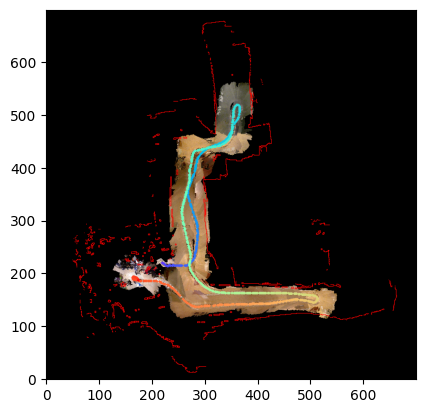

In [14]:
# Extracting the edges
edges = np.zeros_like(texture_map)
for i in range(1, occupancy_map.shape[0] - 1):
    for j in range(1, occupancy_map.shape[1] - 1):
        if occupancy_map[i, j] > 0.5:
            # Check if there is a free cell around
            if np.any(occupancy_map[i - 1:i + 2, j - 1:j + 2] < 0.5):
                edges[i, j] = [1, 1, 1]
# Rotating the edges by 5 degrees
map_center = 350
# edges = cv2.warpAffine(edges, cv2.getRotationMatrix2D((map_center, map_center), 1, 1), (2 * map_center, 2 * map_center))

final_map = texture_map * (1 - edges) + np.array([255, 0, 0]) * edges
plt.imshow(final_map, origin='lower')